In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

import mazelab

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [5]:
env = gym.make('Maze-15x15-FixedGoal-v0')

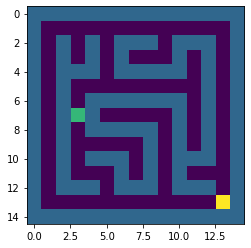

In [6]:
plt.imshow(env.reset())

In [8]:
model = ALGOS['ppo'].load('../agents/ppo/Maze-15x15-FixedGoal-v0_1/Maze-15x15-FixedGoal-v0.zip')

In [110]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=2, device='cuda'):
    obs = np.copy(obs).astype(np.float32)
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs.reshape((1, -1))).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(15, 15, center=loc, radius=radius)
    A = scipy.ndimage.gaussian_filter(obs, 1)
    obs = obs*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs.reshape((1, -1))).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

In [128]:
obs = env.reset().astype(np.float32)

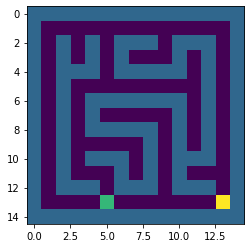

In [129]:
plt.imshow(obs)

In [130]:
b = scipy.ndimage.gaussian_filter(obs, 1)

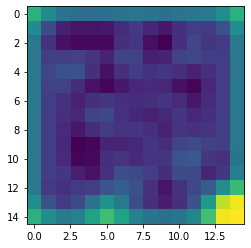

In [131]:
plt.imshow(b)

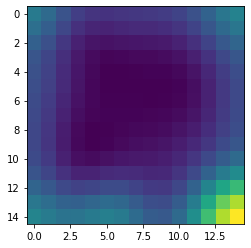

In [132]:
plt.imshow(scipy.ndimage.gaussian_filter(obs, 2))

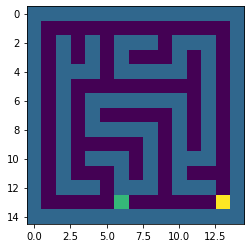

In [136]:
obs = env.reset().astype(np.float32)
plt.imshow(obs)

Text(0.5, 1.0, 'saliency')

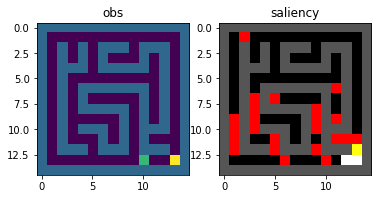

In [174]:
radius = 0
stride = 1

pairs = max_k_and_values(25, product(range(0, 15, stride), range(0, 15, stride)), key=lambda e: policy_saliency(model, obs, e, radius=radius))
max_value = pairs[0][1]

screenshot = np.zeros((15, 15, 3))
screenshot[:, :, 0] = obs
screenshot[:, :, 1] = obs
screenshot[:, :, 2] = obs
screenshot = screenshot / screenshot.max()

for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value / max_value)
    region = create_circular_mask(15, 15, center=loc, radius=radius)
    mask = np.zeros((15, 15, 3))
    mask[:, :, 0] = region
    mask[:, :, 1] = region
    mask[:, :, 2] = region
    spot = np.zeros((15, 15, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    spot = spot / spot.max()
    screenshot = screenshot * (1 - mask) + (spot * mask)
# screenshot = spot / spot.max()

# screenshot /= screenshot.max()
plt.subplot(1, 2, 1)
plt.imshow(obs)
plt.title("obs")
plt.subplot(1, 2, 2)
plt.imshow(screenshot)
plt.title("saliency")

In [164]:
screenshot.max()

1.6666666666666665

In [152]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

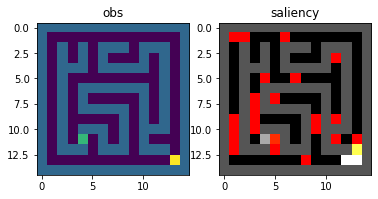

In [179]:
radius = 0
stride = 1

TIMESTEPS = 200

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Maze15x15 Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax1, ax2) = plt.subplots(1, 2)

obs = env.reset()
imshow1 = ax1.imshow(obs)
imshow2 = ax2.imshow(np.zeros((15, 15, 3)))
ax1.set_title("obs")
ax2.set_title("saliency")
with writer.saving(fig, "../videos/maze/maze15x15_policy_saliency_hot.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
            
        pairs = max_k_and_values(25, product(range(0, 15, stride), range(0, 15, stride)), key=lambda e: policy_saliency(model, obs, e, radius=radius))
        max_value = pairs[0][1]
        
        screenshot = np.zeros((15, 15, 3))
        screenshot[:, :, 0] = obs
        screenshot[:, :, 1] = obs
        screenshot[:, :, 2] = obs
        screenshot = screenshot / screenshot.max()
        
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value / max_value)
            region = create_circular_mask(15, 15, center=loc, radius=radius)
            mask = np.zeros((15, 15, 3))
            mask[:, :, 0] = region
            mask[:, :, 1] = region
            mask[:, :, 2] = region
            spot = np.zeros((15, 15, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            spot = spot / spot.max()
            screenshot = screenshot * (1 - mask) + (spot * mask)
        imshow1.set_data(obs)
        imshow2.set_data(screenshot)
        writer.grab_frame()

## Todo: experiment with saliency a bit more

# Let's see about using the gradient for saliency

In [218]:
obs = env.reset()

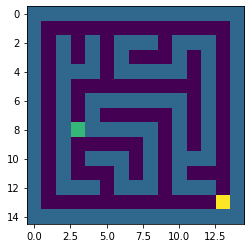

In [219]:
plt.imshow(obs)

In [13]:
action_to_direction = {
    0: "⬆",
    1: "⬇",
    2: "⬅",
    3: "➡"
}

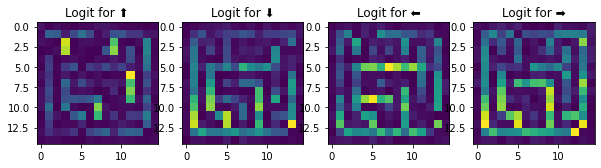

In [252]:
plt.figure(figsize=(10, 10))
for k in range(4):
    obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 225))
    obs_t.requires_grad = True

    policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    model.policy.action_net(policy_latent)[0][k].backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((15, 15))

    plt.subplot(1, 4, k+1)
    plt.title(f"Logit for {action_to_direction[k]}")
    plt.imshow(np.abs(gradients))

In [251]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

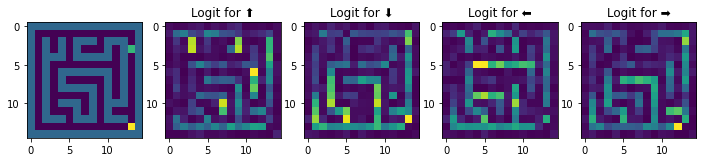

In [298]:
radius = 5
stride = 4

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

with writer.saving(fig, "../videos/maze/maze_policy_saliency_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 225))
            obs_t.requires_grad = True
            policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
            model.policy.action_net(policy_latent)[0][k].backward()
            gradients = obs_t.grad.cpu().detach().numpy().reshape((15, 15))
            gradients = np.abs(gradients)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

In [14]:
def get_logits(obs_t: th.Tensor, model):
    policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    return model.policy.action_net(policy_latent)[0]

def get_grad(obs, model, k=0):
    obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 225))
    obs_t.requires_grad = True
    logits = get_logits(obs_t, model)
    logits[k].backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((15, 15))
    return gradients

def int_grad(obs, model, k=0, dalpha=0.05, baseline=np.zeros((15, 15))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model, k=k) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

In [318]:
[int_grad(obs, model, k=k, dalpha=0.01).sum() for k in range(4)]

[6.742468771291897,
 -1.3234350974817062,
 -1.9689153605140746,
 -4.804497248958796]

In [314]:
with th.no_grad():
    obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 225))
    baseline_t = th.tensor(np.zeros((15, 15))).to(device).to(dtype).reshape((1, 225))
    print(get_logits(obs_t, model) - get_logits(baseline_t, model))

tensor([ 6.6521, -1.5971, -1.8139, -4.4553], device='cuda:0')


### Okay we're passing the sanity check for integrated gradients now!:

$$ \sum_i IG_i(x) = F(x) - F(x'))$$

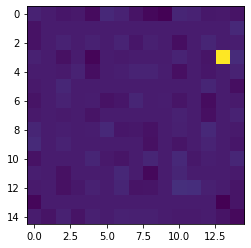

In [327]:
plt.imshow(int_grad(obs, model, k=0, dalpha=0.01))

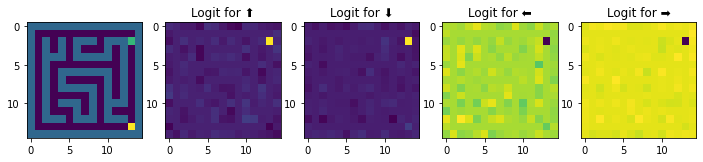

In [328]:
radius = 5
stride = 4

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

with writer.saving(fig, "../videos/maze/maze_policy_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            gradients = int_grad(obs, model, k=k, dalpha=0.01)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

# Let's do a "sanity checks for saliency maps" check

In [334]:
from stable_baselines3 import PPO

In [336]:
model = PPO('MlpPolicy', env)

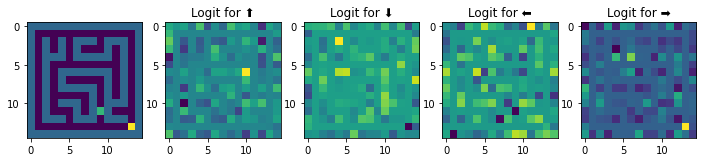

In [338]:
radius = 5
stride = 4

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

with writer.saving(fig, "../videos/maze/maze_policy_saliency_integrated_gradients_random_model.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            gradients = int_grad(obs, model, k=k, dalpha=0.01)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

# Okay it passes the sanity check! The saliency is strikingly different with trained policy vs. a randomly initialized one.


# Let's load up a model for 8x8-RandomMaze and see if the saliency is more complex

In [3]:
env = gym.make('RandomMaze-8x8-FixedGoal-v0')


In [4]:
model = ALGOS['ppo'].load('../agents/ppo/RandomMaze-8x8-FixedGoal-v0_2/RandomMaze-8x8-FixedGoal-v0.zip')


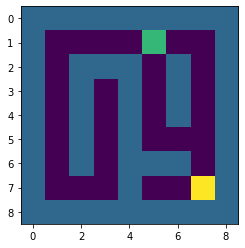

In [9]:
plt.imshow(env.reset())

In [19]:
def get_logits(obs_t: th.Tensor, model):
    policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    return model.policy.action_net(policy_latent)[0]

def get_grad(obs, model, k=0):
    obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 81))
    obs_t.requires_grad = True
    logits = get_logits(obs_t, model)
    logits[k].backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((9, 9))
    return gradients

def int_grad(obs, model, k=0, dalpha=0.05, baseline=np.zeros((9, 9))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model, k=k) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

In [20]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

In [24]:
env.maze.objects.agent.positions

[[5, 4]]

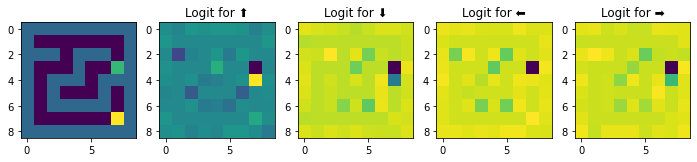

In [32]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Random Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

recent_positions = []

with writer.saving(fig, "../videos/maze/random_maze_policy_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        # determine if stuck
        if len(recent_positions) >= 20:
            if env.maze.objects.agent.positions[0] == recent_positions[0]:
                env.reset()
            else:
                recent_positions.pop(0)
                recent_positions.append(env.maze.objects.agent.positions[0])
        else:
            recent_positions.append(env.maze.objects.agent.positions[0])
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            gradients = int_grad(obs, model, k=k, baseline=np.zeros((9, 9)), dalpha=0.01)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

# What about a policy for when the goal position is randomized?

In [33]:
env = gym.make('EmptyMaze-10x10-RandomGoal-v0')

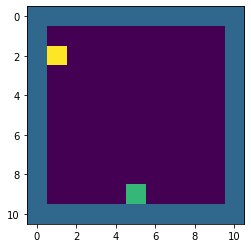

In [34]:
plt.imshow(env.reset())

In [36]:
model = ALGOS['ppo'].load('../agents/ppo/EmptyMaze-10x10-RandomGoal-v0_1/EmptyMaze-10x10-RandomGoal-v0.zip')


In [37]:
def get_logits(obs_t: th.Tensor, model):
    policy_latent, value_latent = model.policy.mlp_extractor(obs_t)
    return model.policy.action_net(policy_latent)[0]

def get_grad(obs, model, k=0):
    obs_t = th.tensor(obs).to(device).to(dtype).reshape((1, 121))
    obs_t.requires_grad = True
    logits = get_logits(obs_t, model)
    logits[k].backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((11, 11))
    return gradients

def int_grad(obs, model, k=0, dalpha=0.05, baseline=np.zeros((11, 11))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model, k=k) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

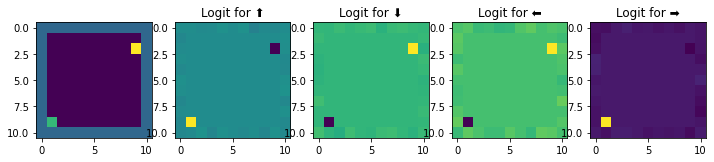

In [39]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Empty Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

recent_positions = []

with writer.saving(fig, "../videos/maze/empty_maze_policy_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        # determine if stuck
        if len(recent_positions) >= 20:
            if env.maze.objects.agent.positions[0] == recent_positions[0]:
                env.reset()
            else:
                recent_positions.pop(0)
                recent_positions.append(env.maze.objects.agent.positions[0])
        else:
            recent_positions.append(env.maze.objects.agent.positions[0])
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            gradients = int_grad(obs, model, k=k, baseline=np.zeros((11, 11)), dalpha=0.01)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

In [40]:
model = ALGOS['ppo']('MlpPolicy', env)

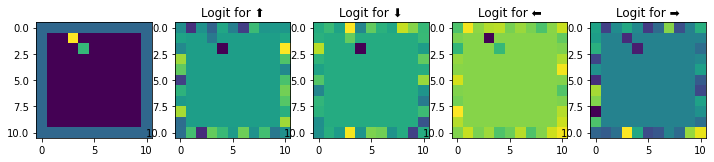

In [41]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Empty Maze Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)

fig, (game, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(12, 3))

obs = env.reset()
game_imshow = game.imshow(obs)

logit_axes = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(logit_axes):
    ax.set_title(f"Logit for {action_to_direction[i]}")
logit_imshows = [ax.imshow(obs) for ax in logit_axes]

recent_positions = []

with writer.saving(fig, "../videos/maze/empty_maze_random_policy_saliency_integrated_gradients.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        # determine if stuck
        if len(recent_positions) >= 20:
            if env.maze.objects.agent.positions[0] == recent_positions[0]:
                env.reset()
            else:
                recent_positions.pop(0)
                recent_positions.append(env.maze.objects.agent.positions[0])
        else:
            recent_positions.append(env.maze.objects.agent.positions[0])
        
        game_imshow.set_data(obs)
        
        for k in range(4):
            gradients = int_grad(obs, model, k=k, baseline=np.zeros((11, 11)), dalpha=0.01)
            logit_imshows[k].set_data(gradients)
            logit_imshows[k].set_clim(gradients.min(), gradients.max())
        writer.grab_frame()
plt.subplots_adjust(hspace=0.5)

# Okay so it 